In [1]:
import sys
print(f'Working with Python {sys.version}')

import numpy as np
import pandas as pd
import importlib
#import swifter
import matplotlib.pyplot as plt
import seaborn as sns
import collections
import time
import os
from rdkit import Chem
from rdkit.Chem import AllChem
from rdkit.Chem import Draw
import rdkit.Chem.Descriptors as Descriptors
from rdkit.Chem import PandasTools
from rdkit import RDLogger
import pymzml
import pyteomics

#
# Load Modules
sys.path.append("..")
from os.path import expanduser
home = expanduser("~")
import modules.IO.mspReader as mspReader
import modules.IO.mgfReader as mgfReader
import modules.visualization.spectrum_visualizer as sv
import modules.IO.molReader as molReader


RDLogger.DisableLog('rdApp.*')


Working with Python 3.10.8 (main, Nov 24 2022, 14:13:03) [GCC 11.2.0]


## Using PyOpenMS

#### Extraction functions

In [2]:
from pyopenms import *
from modules.MS.ms_utility import merge_spectrum, normalize_spectrum
import modules.visualization.spectrum_visualizer as sv
from modules.MS.spectral_scores import spectral_cosine

def extract_compound_spectra(df, rt, precursor_mz, rt_tolerance=0.1, mz_tolerance=0.1):
    df["RT_dif"] = abs(df["RT_min"] - rt)
    r = df["RT_dif"] < rt_tolerance
    p = abs(df["precursor_mz"] - precursor_mz) < mz_tolerance

    return df[np.logical_and(r,p)]

def score_against_merged(df, ref_spec):
    for i, d in df.iterrows():
        df.at[i, 'ref_score'] = spectral_cosine(d["peaks"], ref_spec, transform=np.sqrt)

def merge_df(DF):
    if DF.shape[0] < 0:
        return pd.DataFrame()

    m = None
    for i in range(DF.shape[0]):
        if i == 0:
            m = DF.iloc[i]["peaks"].copy()
        else:
            m = merge_spectrum(m, DF.iloc[i]["peaks"].copy(), merge_tolerance=0.01)

    M = pd.DataFrame({"RT": DF["RT"].mean(), "RT_min": DF["RT_min"].mean(), "precursor_mz": DF["precursor_mz"].mean(), "Instrument_type": "HCD", "NCE": DF["NCE"].mean(), "peaks": [m]})
    score_against_merged(DF, m)
    return M
        
def extract_challenge(file: str, rt: float, precursor_mz: float, rt_tolerance:float=0.1, mz_tolerance:float=0.1, in_ppm=False, verbose: bool=False):
    # Load data
    exp = MSExperiment()
    MzMLFile().load(file, exp)
    
    #Create dataframe with metadata
    df = exp.get_df()
    df["RT_min"] = df["RT"] / 60.0
    df["precursor_mz"] = [spec.getAcquisitionInfo()[0].getMetaValue("[Thermo Trailer Extra]Monoisotopic M/Z:") for spec in exp]
    df["ms_level"] = [spec.getMSLevel() for spec in exp]
    df["filter_string"] = [spec.getMetaValue("filter string") for spec in exp]
    df = df[df["ms_level"] == 2]
    df["hcd"] = df["filter_string"].apply(lambda x: x.split("@")[1].split(" ")[0])
    df["Instrument_type"] = "HCD"
    df["NCE"] = df["hcd"].apply(lambda x: x[3:]).astype(float)
    df["peaks"] = df.apply(lambda x: {"mz": list(x["mzarray"]), "intensity": list(x["intarray"])}, axis=1)
    
    
    
    ## Extract compound spectra
    if in_ppm:
        mz_tolerance = mz_tolerance * precursor_mz
    
    df_extract = extract_compound_spectra(df, rt, precursor_mz, rt_tolerance=rt_tolerance, mz_tolerance=mz_tolerance)
    df_extract["peaks"].apply(normalize_spectrum)

    if verbose: 
        print(f"Extracted {df_extract.shape[0]} spectra with match rt and mz" )

    df_low = df_extract[df_extract["NCE"] == 35.0].sort_values("RT_dif", ascending=True)
    df_med = df_extract[df_extract["NCE"] == 45.0].sort_values("RT_dif", ascending=True)
    df_high = df_extract[df_extract["NCE"] == 65.0].sort_values("RT_dif", ascending=True)
    
    #print(df_low.shape[0],df_med.shape[0],df_high.shape[0] )
    
    challenges = pd.DataFrame()
    ref_scores = []
    if df_low.shape[0] > 0:
        low = merge_df(df_low)
        challenges = pd.concat([challenges, low])
        ref_scores += list(df_low["ref_score"].values)
    
    if df_med.shape[0] > 0:
        med =  merge_df(df_med)
        challenges = pd.concat([challenges, med])
        ref_scores += list(df_med["ref_score"].values)

    if df_high.shape[0] > 0:    
        high = merge_df(df_high)
        challenges = pd.concat([challenges, high])
        ref_scores += list(df_high["ref_score"].values)

    # print(challenges)
    if challenges.shape[0] == 0:
        print("Warning: Could not extract challenge!!! No matches found.")
    else:
        min_ref_score = min(ref_scores)
        if min_ref_score < 0.9:
            print(f"Warning: Low cosine score of {min_ref_score:.2f} detected. (All ref_scores {ref_scores})")
            #raise Warning("Low cosine score detected between merged spectrum and at least one experimental spectrum. Tolerance values might have picked up a false RT/MZ match")

    if verbose: 
        print(f"\nMerged {df_low.shape[0]} with NCE 35" )
        print(df_low["ref_score"])
        print(f"\nMerged {df_med.shape[0]} with NCE 45" )
        print(df_med["ref_score"])
        print(f"\nMerged {df_high.shape[0]} with NCE 65" )
        print(df_high["ref_score"])
        sv.plot_spectrum(df_low.iloc[0], challenges.iloc[0])
        sv.plot_spectrum(df_med.iloc[0], challenges.iloc[1])
        sv.plot_spectrum(df_high.iloc[0], challenges.iloc[2])
        plt.show()
        
        print(f"Minimum cosine score to merged spectra: {min_ref_score:.2f} (pass)")
        
    return challenges, ref_scores

#### Do a test extraction (challenge 3)

Extracted 7 spectra with match rt and mz

Merged 3 with NCE 35
2671    0.982685
2685    0.984239
2696    0.976372
Name: ref_score, dtype: float64

Merged 2 with NCE 45
2673    0.994114
2690    0.987270
Name: ref_score, dtype: float64

Merged 2 with NCE 65
2675    0.987082
2693    0.981490
Name: ref_score, dtype: float64


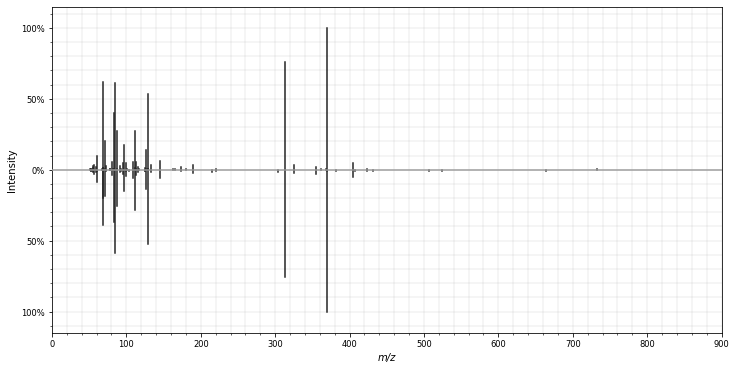

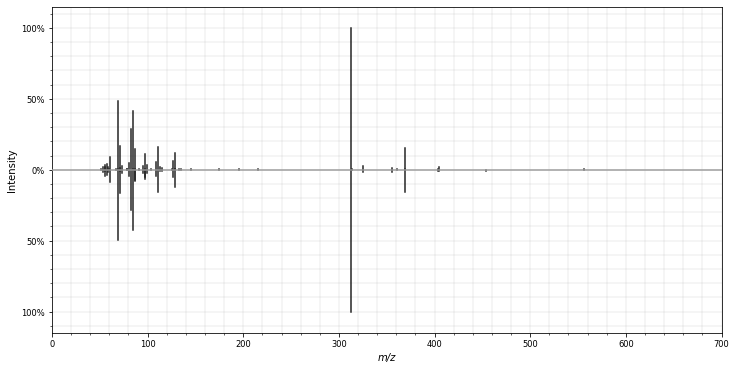

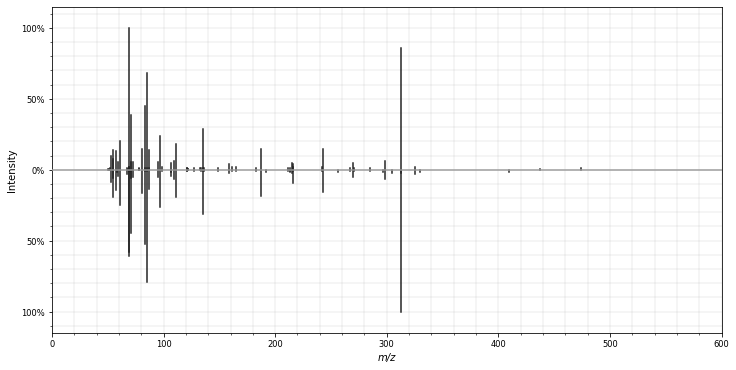

Minimum cosine score to merged spectra: 0.98 (pass)


(           RT    RT_min  precursor_mz Instrument_type   NCE  \
 0  336.971576  5.616193    719.253885             HCD  35.0   
 0  336.741438  5.612357    719.253772             HCD  45.0   
 0  336.963120  5.616052    719.253839             HCD  65.0   
 
                                                peaks  
 0  {'mz': [50.65100860595703, 52.452545166015625,...  
 0  {'mz': [51.71462631225586, 53.03887939453125, ...  
 0  {'mz': [50.59212112426758, 51.15884780883789, ...  ,
 [0.9826853290715883,
  0.9842385837299347,
  0.9763716958759602,
  0.9941140128100651,
  0.9872700657527452,
  0.9870815402182579,
  0.9814899523979597])

In [3]:
l = f"{home}/data/metabolites/CASMI_2022/download/"
f = "A_M3_posPFP_01.mzml"
path = os.path.join(l, f)



extract_challenge(path, 5.55, 719.2546, verbose=True)

In [4]:
l = f"{home}/data/metabolites/CASMI_2022/"
key_file = "MetSoc2022_CASMI_Workshop_Challenges_KEY_ALL_FINAL.csv"
challenge_key = pd.read_csv(os.path.join(l, key_file), sep='\t')
challenge_key.head(3)

,Compound Number,File,RT [min],Precursor m/z (Da),Priority/Bonus,Adduct,InChIKey,SMILES,Collection,Rack ID or UCD Barcode,Well ID,Formula,Monoisotopic Mass,Mix or Set Number
0,1,A_M28_negPFP_04,1.67,517.2210,Priority,[M+Cl]-,ZUDBDCBPZHGAEL-DCYCNZAJSA-N,CC12CC(CC(C1CCC34C2CCC(C3)C(=C)C4O)C(=O)O)OC5C...,Analyticon,AD205398-02,E01,C25H38O9,482.2516,M-28
1,2,A_M8_negPFP_03,3.70,959.4857,Priority,[M+FA-H]-,ZKCHQVRAXCCTLE-YXHZOQBQSA-N,CC1(C2CCC3(C(C2(CCC1OC4C(C(C(CO4)OC5C(C(C(C(O5...,Analyticon,AD205398-04,E01,C46H74O18,914.4875,M-8
2,3,A_M3_posPFP_01,5.55,719.2546,Priority,[M+H]+,UYALDZZEAZIEME-MYTBKXFISA-N,CC1C(C(C(C(O1)OC2=C(OC3=C(C(=CC(=C3C2=O)O)O)CC...,Analyticon,AD205398-03,E02,C35H42O16,718.2473,M-3


(285, 14)


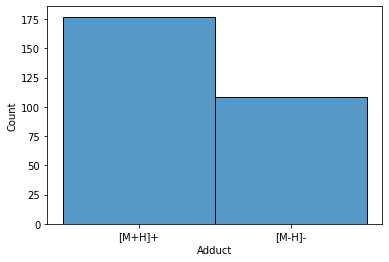

,Compound Number,File,RT [min],Precursor m/z (Da),Priority/Bonus,Adduct,InChIKey,SMILES,Collection,Rack ID or UCD Barcode,Well ID,Formula,Monoisotopic Mass,Mix or Set Number
2,3,A_M3_posPFP_01,5.55,719.2546,Priority,[M+H]+,UYALDZZEAZIEME-MYTBKXFISA-N,CC1C(C(C(C(O1)OC2=C(OC3=C(C(=CC(=C3C2=O)O)O)CC...,Analyticon,AD205398-03,E02,C35H42O16,718.2473,M-3
6,7,A_M24_negPFP_03,1.99,577.1563,Priority,[M-H]-,LYKXPTCUGPKDQL-ZRXCBZTOSA-N,CC1C(C(C(C(O1)OC2C(C(C(OC2OC3=CC(=CC4=C3C(=O)C...,Analyticon,AD205398-02,D05,C27H30O14,578.1636,M-24
7,8,A_M6_negPFP_03,6.29,371.2439,Priority,[M-H]-,RZCUHAHZISRSJD-UHFFFAOYSA-N,CCCCCCCCCC(=O)OC(C(C(C)C)OC(=O)C(C)C)C(=O)O,Analyticon,AD205398-03,D05,C20H36O6,372.2512,M-6


In [5]:

challenge_key = challenge_key[np.logical_or(challenge_key["Adduct"] == "[M+H]+", challenge_key["Adduct"] == "[M-H]-")]

print(challenge_key.shape)

sns.histplot(challenge_key, x="Adduct")
plt.show()
challenge_key.head(3)

In [6]:
from modules.MOL.constants import PPM

challenges = pd.DataFrame()
misses = 0
avg_ref_score = []
avg_min_ref_score = []
avg_num_spectra = []


for i, d in challenge_key.iterrows():
    file = d["File"] + ".mzml"
    rt = d["RT [min]"]
    precursor_mz = d["Precursor m/z (Da)"]
    adduct = d["Adduct"]
    name = d["Compound Number"]
    smiles = d["SMILES"].strip()
    
    path = os.path.join(l, "mzml/", file)
            
    c, ref_scores = extract_challenge(path, rt, precursor_mz, rt_tolerance=2.5 / 60.0, mz_tolerance=10 * PPM, in_ppm=True, verbose=False) # 5 seconds torance, 10 ppm precursor mass
    if c.shape[0] == 0:
        print(f"No match found for Compound Number {name}")
        misses += 1
        continue
    avg_ref_score += ref_scores
    avg_min_ref_score += [min(ref_scores)]
    avg_num_spectra += [len(ref_scores)]
    c["Precursor_type"] = adduct
    c["ChallengeName"] = "Challenge-"+str(name)
    c["ChallengeRT"] = rt
    c["SMILES"] = smiles
    challenges = pd.concat([challenges, c], axis=0)


No match found for Compound Number 3
No match found for Compound Number 11
No match found for Compound Number 21
No match found for Compound Number 22
No match found for Compound Number 46
No match found for Compound Number 48
No match found for Compound Number 64
No match found for Compound Number 78
No match found for Compound Number 79
No match found for Compound Number 88
No match found for Compound Number 91
No match found for Compound Number 102
No match found for Compound Number 116
No match found for Compound Number 118
No match found for Compound Number 122
No match found for Compound Number 129
No match found for Compound Number 130
No match found for Compound Number 141
No match found for Compound Number 153
No match found for Compound Number 159
No match found for Compound Number 163
No match found for Compound Number 165
No match found for Compound Number 169
No match found for Compound Number 190
No match found for Compound Number 201
No match found for Compound Number 20

In [7]:
challenges[challenges["ChallengeName"] == "Challenge-277"]["SMILES"]#.apply(lambda x: x.strip())

0    CC1C(=O)C(O)(C(O)C=1O)C(=O)CC(C)C
0    CC1C(=O)C(O)(C(O)C=1O)C(=O)CC(C)C
0    CC1C(=O)C(O)(C(O)C=1O)C(=O)CC(C)C
Name: SMILES, dtype: object

In [8]:
challenges.head()

,RT,RT_min,precursor_mz,Instrument_type,NCE,peaks,Precursor_type,ChallengeName,ChallengeRT,SMILES
0,120.806352,2.013439,577.155724,HCD,35.0,"{'mz': [53.119319915771484, 59.01255798339844,...",[M-H]-,Challenge-7,1.99,CC1C(C(C(C(O1)OC2C(C(C(OC2OC3=CC(=CC4=C3C(=O)C...
0,121.059222,2.017654,577.155690,HCD,45.0,"{'mz': [59.01255798339844, 67.25941467285156, ...",[M-H]-,Challenge-7,1.99,CC1C(C(C(C(O1)OC2C(C(C(OC2OC3=CC(=CC4=C3C(=O)C...
0,120.632094,2.010535,577.155634,HCD,65.0,"{'mz': [59.0126838684082, 63.0227165222168, 63...",[M-H]-,Challenge-7,1.99,CC1C(C(C(C(O1)OC2C(C(C(OC2OC3=CC(=CC4=C3C(=O)C...
0,377.869288,6.297821,371.243076,HCD,35.0,"{'mz': [51.04441833496094, 55.555946350097656,...",[M-H]-,Challenge-8,6.29,CCCCCCCCCC(=O)OC(C(C(C)C)OC(=O)C(C)C)C(=O)O
0,378.278562,6.304643,371.243207,HCD,45.0,"{'mz': [54.54650115966797, 84.15945434570312, ...",[M-H]-,Challenge-8,6.29,CCCCCCCCCC(=O)OC(C(C(C)C)OC(=O)C(C)C)C(=O)O


In [9]:
print(f"Missed compounds: {misses}")
print(f"Mean ref score: {np.mean(avg_ref_score)}")
print(f"Mean min score: {np.mean(avg_min_ref_score)}")
print(f"Median num spec: {np.median(avg_num_spectra)}")

Missed compounds: 59
Mean ref score: 0.9841709916322262
Mean min score: 0.9684028864189829
Median num spec: 7.0


In [ ]:
raise KeyboardInterrupt("Stop. Make sure you want to save the DataFrames")

#### Save DF

In [ ]:
save_df = True
name = "casmi22_challenges_combined_accurate.csv"

if save_df:
       file = os.path.join(l, name)
       print("saving to ", file)
       challenges.to_csv(file)
       
       #df_nist[key_columns].to_csv(library_directory + name + "all" + "_" + date + ".csv")



#### Save CFM-id format

In [11]:
## prepare output for for CFM-ID
save_df = False
cfm_directory = f"{home}/data/metabolites/cfm-id/"
name = "casmi22_negative_solutions_cfm.txt"
unique_challenges = challenges.drop_duplicates(subset='ChallengeName', keep='first')

if save_df:
    file = os.path.join(cfm_directory, name)
    print("saving to ", file)
    unique_challenges[unique_challenges["Precursor_type"] == "[M-H]-"][["ChallengeName", "SMILES"]].to_csv(file, index=False, header=False, sep=" ")
    
    name = name.replace("negative", "positive")
    file = os.path.join(cfm_directory, name)
    print("saving to ", file)
    unique_challenges[unique_challenges["Precursor_type"] == "[M+H]+"][["ChallengeName", "SMILES"]].to_csv(file, index=False, header=False, sep=" ")

In [ ]:
raise KeyboardInterrupt("Until here. AND NO FURTHER")

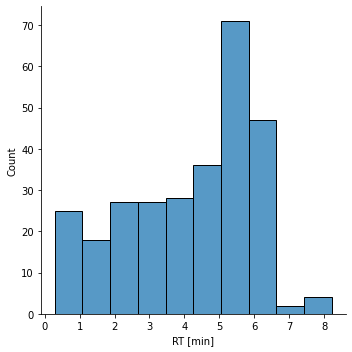

In [ ]:
sns.displot(challenge_key, x="RT [min]")

In [ ]:
raise ValueError("STOP HERE")

In [ ]:
comp = [46, 64, 78, 79, 118, 130, 163, 165]

print(challenge_key[challenge_key["Compound Number"] == 78])

#print(extract_challenge(249.1496))

    Compound Number             File  RT [min]  Precursor m/z (Da)  \
77               78  E_M41_posPFP_01      4.33            414.0215   

   Priority/Bonus  Adduct                     InChIKey  \
77       Priority  [M+H]+  LVASCWIMLIKXLA-LSDHHAIUSA-N   

                                              SMILES Collection  \
77  C1CC(C(NC1)CC(=O)CN2C=NC3=CC(=C(C=C3C2=O)Cl)Br)O  Emolcules   

   Rack ID or UCD Barcode Well ID         Formula  Monoisotopic Mass  \
77              139759317      --  C16H17BrClN3O3           413.0142   

   Mix or Set Number  
77                41  


In [ ]:
merge_df(df_low)

In [ ]:
peaks1 = {"mz": [2.5, 2.8, 5], "intensity": [8, 5, 9]}
peaks2 = {"mz": [2.51, 3.0, 10], "intensity": [2, 2, 2]}
normalize_spectrum(peaks1, "norm")
normalize_spectrum(peaks2, "norm")

mm = merge_spectrum(peaks1, peaks2, merge_tolerance=0.01)
print(peaks1)
print(peaks2)
print(mm)

{'mz': [3.0, 10], 'intensity': [0.5773502691896258, 0.5773502691896258]}
{'mz': [2.5, 2.8, 5], 'intensity': [0.6135719910778963, 0.3834824944236852, 0.6902684899626333]}
{'mz': [2.51, 3.0, 10], 'intensity': [0.5773502691896258, 0.5773502691896258, 0.5773502691896258]}
{'mz': [2.505, 2.8, 5, 3.0, 10], 'intensity': [1.1909222602675222, 0.3834824944236852, 0.6902684899626333, 0.5773502691896258, 0.5773502691896258]}


In [ ]:
print(mm)
print(spectral_cosine(peaks1, peaks2))
print(spectral_cosine(peaks1, mm))
print(spectral_cosine(peaks2, mm))

{'mz': [2.505, 2.8, 5, 3.0, 10], 'intensity': [1.1909222602675222, 0.3834824944236852, 0.6902684899626333, 0.5773502691896258, 0.5773502691896258]}
0.35424595421603816
0.822874824689648
0.8228748246896481


In [ ]:
cos, mz_map, bins, bins_ref = spectral_cosine(peaks1, mm)

In [ ]:
mz_map

{2.5: 0, 2.51: 0, 2.8: 2, 3.0: 3, 5.0: 4, 10.0: 5}

In [ ]:
bins

[0, 2, 4, 0, 3, 5]

In [ ]:
vec, vec_ref = np.zeros(len(mz_map)), np.zeros(len(mz_map)) 
np.add.at(vec, bins, peaks1["intensity"]) #vec.put(bins, spec["intensity"])
np.add.at(vec_ref, bins_ref, mm["intensity"])   

print(vec)
print(vec_ref)

[10.  0.  5.  2.  9.  2.]
[10.  0.  5.  2.  9.  2.]


In [ ]:
bins_ref

[0, 2, 4, 0, 3, 5]

In [ ]:
raise KeyboardInterrupt

In [ ]:
print(df_low.iloc[0]["peaks"]["mz"][-10:])
print(df_low.iloc[1]["peaks"]["mz"][-10:])


[221.16720581 313.07043457 325.07028198 355.0821228  361.1105957
 369.00958252 369.13302612 405.09713745 423.10928345 733.08276367]
[313.07040405 325.0710144  355.08129883 369.13275146 374.11923218
 405.09451294 423.10626221 431.07653809 680.41784668 715.34387207]


In [ ]:
405.09451294 - 405.09713745

-0.002624509999975544

In [ ]:
print(spec.getRT() / 60)
print(spec.g() / 60)

5.5959313


In [ ]:
for i in spec.getAcquisitionInfo():
    print(i.getMetaValue("[Thermo Trailer Extra]Monoisotopic M/Z:"))

719.2538669839563


In [ ]:
spec.getAcquisitionInfo()[0].getMetaValue("[Thermo Trailer Extra]Monoisotopic M/Z:")

719.2538669839563

### STOP

### PYMZML

(0.0063682887, 'minute')


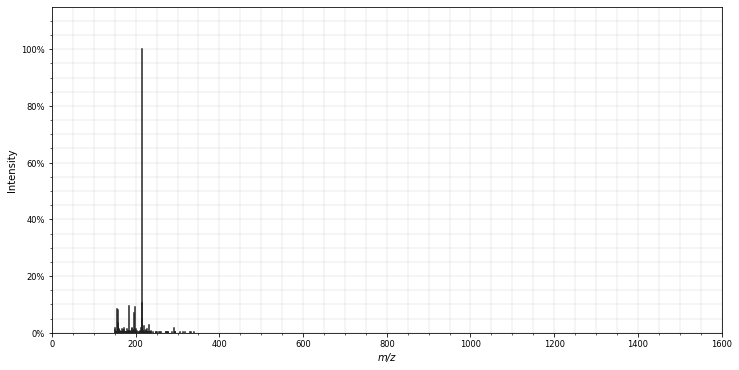

In [4]:
#l = f"{home}/data/metabolites/CASMI_2022/3_Data-20220516T091400Z-001/3_Data/mzML Data/1_Priority - Challenges 1-250/pos"
l = f"{home}/data/metabolites/CASMI_2022/download/"
f = "A_M3_posPFP_01.mzml"

run = pymzml.run.Reader(os.path.join(l, f))

for spec in run:
    mz, intensity = spec.peaks("centroided")[:,0],spec.peaks("centroided")[:,1] 
    print(spec.scan_time)
    for i in spec.__dir__():
        if "filter" in i:
            print(i)
    sv.plot_spectrum({"peaks": {"mz": mz, "intensity": intensity}})
    plt.show()
    break

In [5]:
from pyteomics import mzml, auxiliary, mgf
path = os.path.join(l, f)
reader = mzml.read(path)
auxiliary.print_tree(next(reader))

index
id
defaultArrayLength
dataProcessingRef
scanList
 -> count
 -> scan [list]
 ->  -> scanWindowList
 ->  ->  -> count
 ->  ->  -> scanWindow [list]
 ->  ->  ->  -> scan window lower limit
 ->  ->  ->  -> scan window upper limit
 ->  -> scan start time
 ->  -> filter string
 ->  -> preset scan configuration
 ->  -> ion injection time
 -> no combination
MS1 spectrum
ms level
positive scan
centroid spectrum
base peak m/z
base peak intensity
total ion current
lowest observed m/z
highest observed m/z
spectrum title
count
m/z array
intensity array


In [ ]:
os.path.join(l, f)

In [ ]:
for x in data:
    print(x)

## Matchms


In [6]:
from matchms.importing import load_from_mzml
from matchms.filtering import default_filters

reader = load_from_mzml(path)


In [ ]:
#print(next(reader).metadata)

{'charge': 1, 'scan_number': None, 'title': 'A_M3_posPFP_01.461.461.1 File:"A_M3_posPFP_01.raw", NativeID:"controllerType=0 controllerNumber=1 scan=461"', 'precursor_mz': 199.09630137654, 'scan_start_time': [1.0459766], 'retention_time': []}


In [9]:
spectrums = []
for spectrum in reader:
    # Apply default filter to standardize ion mode, correct charge and more.
    # Default filter is fully explained at https://matchms.readthedocs.io/en/latest/api/matchms.filtering.html .
    #spectrum = default_filters(spectrum)
    spectrums.append(spectrum)

In [10]:
df = pd.DataFrame([{"spectrum": s, **s.metadata} for s in spectrums])

In [11]:
df["RT"] = df.scan_start_time.apply(lambda x: x[0])
df["is_rt_match"] = abs(df["RT"] - 5.55) < 0.1

df["is_mz_match"] = abs(df["precursor_mz"] - 719.2546) < 0.1
df["is_match"] = np.logical_and(df["is_rt_match"], df["is_mz_match"])
example = df[df["is_match"]].iloc[0]
spec = example["spectrum"]
print()


In [14]:
df.head()

,spectrum,charge,scan_number,title,precursor_mz,scan_start_time,retention_time,RT,is_rt_match,is_mz_match,is_match
0,<matchms.Spectrum.Spectrum object at 0x7ff412d...,1.0,None,"A_M3_posPFP_01.461.461.1 File:""A_M3_posPFP_01....",199.096301,[1.0459766],[],1.045977,False,False,False
1,<matchms.Spectrum.Spectrum object at 0x7ff4114...,1.0,None,"A_M3_posPFP_01.463.463.1 File:""A_M3_posPFP_01....",199.096328,[1.0491517],[],1.049152,False,False,False
2,<matchms.Spectrum.Spectrum object at 0x7ff412f...,1.0,None,"A_M3_posPFP_01.465.465.1 File:""A_M3_posPFP_01....",199.096305,[1.0520434],[],1.052043,False,False,False
3,<matchms.Spectrum.Spectrum object at 0x7ff4130...,1.0,None,"A_M3_posPFP_01.470.470.1 File:""A_M3_posPFP_01....",199.096312,[1.0626974],[],1.062697,False,False,False
4,<matchms.Spectrum.Spectrum object at 0x7ff412d...,1.0,None,"A_M3_posPFP_01.475.475.1 File:""A_M3_posPFP_01....",199.096330,[1.0725244],[],1.072524,False,False,False


In [ ]:
spec.__dir__()

['_metadata',
 '_peaks',
 '_losses',
 '__module__',
 '__doc__',
 '_peak_comments_mz_tolerance',
 '__init__',
 '__eq__',
 '__hash__',
 'spectrum_hash',
 'metadata_hash',
 'clone',
 'plot',
 'plot_against',
 'get',
 'set',
 'to_dict',
 'metadata_dict',
 'mz',
 'intensities',
 'metadata',
 'losses',
 'peaks',
 'peak_comments',
 'update_peak_comments_mz_tolerance',
 '_reiterate_peak_comments',
 '__dict__',
 '__weakref__',
 '__new__',
 '__repr__',
 '__str__',
 '__getattribute__',
 '__setattr__',
 '__delattr__',
 '__lt__',
 '__le__',
 '__ne__',
 '__gt__',
 '__ge__',
 '__reduce_ex__',
 '__reduce__',
 '__subclasshook__',
 '__init_subclass__',
 '__format__',
 '__sizeof__',
 '__dir__',
 '__class__']

### PyOpenMS


In [ ]:
from pyopenms import *


print(open(path).readlines()[197].strip())
print(path)


In [ ]:
from pyopenms import *
exp = MSExperiment()
MzMLFile().load(path, exp)

print( exp.getSpectrum(1).get_peaks()[0] )
# [ 0.  2.  4.  6.  8. 10. 12. 14. 16. 18.]

[150.95095825 151.03511047 151.07504272 151.11190796 151.93725586
 151.94950867 152.03588867 152.9467926  152.95077515 152.99475098
 153.03266907 153.09085083 153.12730408 153.948349   153.99330139
 154.01623535 154.9667511  154.99005127 155.10649109 155.98716736
 155.990448   155.99356079 156.96583557 156.99053955 156.99801636
 157.01095581 157.02749634 157.03503418 157.08564758 157.97363281
 158.00271606 158.02391052 158.02687073 158.03442383 158.03837585
 158.08076477 158.96116638 158.98597717 159.00619507 159.01115417
 159.03060913 159.96101379 159.96485901 159.96896362 160.0227356
 160.02738953 160.64637756 160.96470642 160.9728241  161.02581787
 161.05924988 161.09585571 162.1131897  162.97348022 162.9980011
 163.07514954 163.13269043 163.94029236 164.06660461 165.0063324
 165.98257446 166.99510193 167.01263428 167.10650635 167.54824829
 167.95397949 167.96342468 167.98204041 167.99839783 168.01611328
 168.56494141 168.96131897 169.04592896 169.08576965 169.12207031
 169.96011353

In [ ]:
getters = [x for x in exp.getSpectrum(1).__dir__() if "get" in x]
spec1 = None

for spec in exp:
    if abs(spec.getRT() - 5.55) < 0.1:
        #if spec.getMSLevel() == 2:
       spec1 = spec
       break

print(spec1)




In [ ]:
print(spec1.getMetaValue("filter string"))

FTMS + c ESI Full ms [150.0000-1500.0000]


In [ ]:

for g in getters:
    print(getattr(spec1, g))

<method-wrapper '__getitem__' of pyopenms._pyopenms_4.MSSpectrum object at 0x7fdb279a9430>
<built-in method getRT of pyopenms._pyopenms_4.MSSpectrum object at 0x7fdb279a9430>
<built-in method getDriftTime of pyopenms._pyopenms_4.MSSpectrum object at 0x7fdb279a9430>
<built-in method getDriftTimeUnit of pyopenms._pyopenms_4.MSSpectrum object at 0x7fdb279a9430>
<built-in method getDriftTimeUnitAsString of pyopenms._pyopenms_4.MSSpectrum object at 0x7fdb279a9430>
<built-in method getMSLevel of pyopenms._pyopenms_4.MSSpectrum object at 0x7fdb279a9430>
<built-in method getName of pyopenms._pyopenms_4.MSSpectrum object at 0x7fdb279a9430>
<built-in method getFloatDataArrays of pyopenms._pyopenms_4.MSSpectrum object at 0x7fdb279a9430>
<built-in method getIntegerDataArrays of pyopenms._pyopenms_4.MSSpectrum object at 0x7fdb279a9430>
<built-in method getStringDataArrays of pyopenms._pyopenms_4.MSSpectrum object at 0x7fdb279a9430>
<built-in method getType of pyopenms._pyopenms_4.MSSpectrum object 

In [ ]:
getters

['__getitem__',
 'getRT',
 'getDriftTime',
 'getDriftTimeUnit',
 'getDriftTimeUnitAsString',
 'getMSLevel',
 'getName',
 'getFloatDataArrays',
 'getIntegerDataArrays',
 'getStringDataArrays',
 'getType',
 'getNativeID',
 'getComment',
 'getInstrumentSettings',
 'getAcquisitionInfo',
 'getSourceFile',
 'getPrecursors',
 'getProducts',
 'getPeptideIdentifications',
 'getDataProcessing',
 'getKeys',
 'getMetaValue',
 'getMinMZ',
 'getMaxMZ',
 'getMinIntensity',
 'getMaxIntensity',
 'get_peaks',
 'getIMData',
 '__getattribute__']

In [ ]:
spec = exp.getSpectrum(4634)
spec.getMSLevel()

1

In [ ]:
from pyopenms import *
exp = MSExperiment()
MzMLFile().load(path, exp)

# print( exp.getSpectrum(1).get_peaks()[0] )
# [ 0.  2.  4.  6.  8. 10. 12. 14. 16. 18.]

In [ ]:
df = exp.get_df()

In [ ]:
df.columns

Index(['RT', 'mzarray', 'intarray'], dtype='object')

In [ ]:
for spec in exp:
    if spec.getMSLevel() == 2:
        print(spec)

In [ ]:
lines = open(path).readlines()

for line in lines:
    line = line.strip()
    if 'scan=2672' in line: print(line)
    #if 'name="ms level" value="2"' in line: print(line)

<spectrum index="2671" id="controllerType=0 controllerNumber=1 scan=2672" defaultArrayLength="60" dataProcessingRef="pwiz_Reader_Thermo_conversion">
<cvParam cvRef="MS" accession="MS:1000796" name="spectrum title" value="A_M3_posPFP_01.2672.2672.1 File:&quot;A_M3_posPFP_01.raw&quot;, NativeID:&quot;controllerType=0 controllerNumber=1 scan=2672&quot;"/>
<offset idRef="controllerType=0 controllerNumber=1 scan=2672">21959391</offset>


In [ ]:
spec = exp.getSpectrum(2671)

In [ ]:
print(spec.getKeys())

In [ ]:
print(spec.getMetaValue("base peak m/z"))
print(spec.getMetaValue("base peak intensity"))
print(spec.getMetaValue("total ion current"))
print(spec.getMetaValue("filter string"))
print(spec.getMetaValue("[Thermo Trailer Extra]Monoisotopic M/Z:"))
print(spec.getMSLevel())
print(spec.getMSLevel() == 2)


369.1330389
781297.69
4647710.0
FTMS + c ESI d Full ms2 719.2538@hcd35.00 [50.0000-750.0000]
None
2
True


In [ ]:
a = spec.getPrecursors()
a


[]

In [ ]:
for spec in exp:
    if spec.getMSLevel() == 2:
        print(spec)

In [ ]:
print(spec.getAcquisitionInfo().getMetaValue("filter string"))

None


In [ ]:
scan=2672

In [ ]:
from pyopenms import *
exp = MSExperiment()
MzMLFile().load(path, exp)


for spec in exp:
    if spec.getMSLevel() == 2:
        if abs(spec.getRT() - 5.55) < 0.1:
            print("yes")